In [3]:
!pip install -q scikit-image opencv-python-headless matplotlib transformers torch scikit-learn pillow


Device: cuda

Loading images...
✓ Images loaded: 720×720

Computing SSIM and pixel differences...
  SSIM Score: 0.9942

Generating 10 SSIM+PixelDiff fusion maps...
  ✓ Generated 10 fusion maps

Multi-scale contour detection (using global thresholds)...
  ✓ Generated masks for 3 threshold levels

K-means clustering on difference maps...
  ✓ K-means clustering complete (anomaly cluster: 1)

Aggregating all detection methods...
  ✓ Change score: 0.64%
  ✓ Changed pixels: 3,321 / 518,400

Extracting region proposals...
  ✓ Generated 3 proposals

Loading SAM 2.1 model for mask refinement...


Device set to use cuda


🔹 Running SAM on 3 detected regions...
  ✓ Refined 3 regions with SAM

Generating visualization...


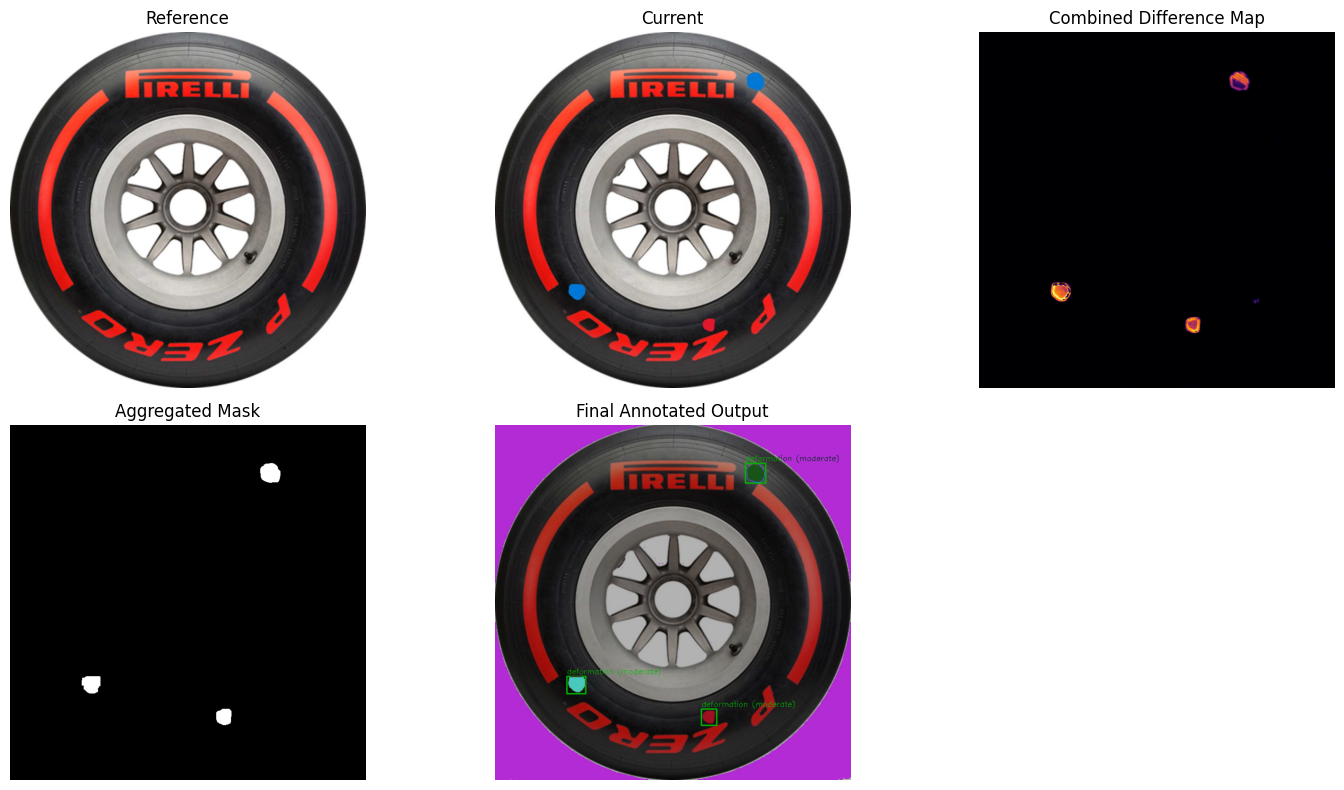

✓ Visualization saved as ensemble_detection_simple.png

🎯 ENSEMBLE DETECTION COMPLETE
Methods: 10 SSIM+Pixel fusions × 3 Thresholds + K-means + SAM2
SSIM: 0.9942 | Change: 0.64%
Detections: 3 regions
Files: ensemble_detection_simple.png, ensemble_results.json


In [4]:
# ========================================================================
# ENSEMBLE VISUAL DIFFERENCE ENGINE
# Multi-method aggregation: SSIM+PixelDiff fusion (10 weights) +
# Multi-scale Contours (3 thresholds) + K-means clustering + SAM2
# ========================================================================

import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.metrics import structural_similarity as ssim
from sklearn.cluster import KMeans
from transformers import pipeline  # Using pipeline for simplicity
import torch
import json
from PIL import Image # Need PIL for transformers pipeline
import warnings
warnings.filterwarnings('ignore')

# ========================================================================
# CONFIGURATION
# ========================================================================

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Device: {device}\n")

# Image paths
ref_path = "/content/race_car_tire_1.jpeg"
curr_path = "/content/race_car_tire_1_anomaly.jpeg"

# ========================================================================
# STEP 1: LOAD & PREPROCESS IMAGES
# ========================================================================

print("Loading images...")
ref = cv2.imread(ref_path)
curr = cv2.imread(curr_path)

if ref is None or curr is None:
    raise ValueError("Invalid image paths!")

# Ensure same dimensions
if ref.shape != curr.shape:
    curr = cv2.resize(curr, (ref.shape[1], ref.shape[0]))

h, w = ref.shape[:2]
ref_gray = cv2.cvtColor(ref, cv2.COLOR_BGR2GRAY)
curr_gray = cv2.cvtColor(curr, cv2.COLOR_BGR2GRAY)

print(f"✓ Images loaded: {w}×{h}\n")

# ========================================================================
# STEP 2: METHOD 1 - SSIM + PIXEL DIFF (10 WEIGHT COMBINATIONS)
# ========================================================================

print("Computing SSIM and pixel differences...")

# SSIM difference map
ssim_score, ssim_diff = ssim(ref_gray, curr_gray, full=True)
ssim_diff = (1 - ssim_diff) * 255
ssim_diff = ssim_diff.astype(np.uint8)

# Absolute pixel difference
pixel_diff = cv2.absdiff(ref_gray, curr_gray)
print(f"  SSIM Score: {ssim_score:.4f}\n")

# Generate 10 fusion weight combinations
print("Generating 10 SSIM+PixelDiff fusion maps...")
alphas = np.linspace(0.1, 1.0, 10)  # SSIM weights
fusion_maps = []

for alpha in alphas:
    fused = cv2.addWeighted(ssim_diff, alpha, pixel_diff, 1-alpha, 0)
    fusion_maps.append(fused)
print(f"  ✓ Generated {len(fusion_maps)} fusion maps\n")

# ========================================================================
# STEP 3: METHOD 2 - MULTI-SCALE CONTOUR DETECTION (CORRECTED)
# ========================================================================

print("Multi-scale contour detection (using global thresholds)...")
# --- IMPROVEMENT ---
# Replaced 'block_sizes' with 'threshold_values'
# Replaced 'cv2.adaptiveThreshold' with 'cv2.threshold'
threshold_values = [30, 50, 70]  # Low, medium, high sensitivity
all_contour_masks = []
kernel_3x3 = np.ones((3, 3), np.uint8)

for thresh_val in threshold_values:
    thresh_masks = []

    for fused_map in fusion_maps:
        # Use simple global threshold (the correct tool)
        _, thresh = cv2.threshold(fused_map, thresh_val, 255, cv2.THRESH_BINARY)

        # Morphological cleanup
        clean = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel_3x3, iterations=2)
        clean = cv2.morphologyEx(clean, cv2.MORPH_CLOSE, kernel_3x3, iterations=2)

        thresh_masks.append(clean)

    # Aggregate for this threshold value
    thresh_agg = np.maximum.reduce(thresh_masks)
    all_contour_masks.append(thresh_agg)

# Aggregate all threshold levels
contour_mask_final = np.maximum.reduce(all_contour_masks)

print(f"  ✓ Generated masks for {len(threshold_values)} threshold levels\n")

# ========================================================================
# STEP 4: METHOD 3 - K-MEANS CLUSTERING ON DIFFERENCE MAPS
# ========================================================================

print("K-means clustering on difference maps...")

# Stack all fusion maps
fusion_stack = np.stack(fusion_maps, axis=-1)  # [H, W, 10]
fusion_flat = fusion_stack.reshape(-1, 10)

# K-means with 3 clusters (background, minor change, major change)
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
labels = kmeans.fit_predict(fusion_flat)
labels = labels.reshape(h, w)

# Find cluster with highest mean intensity (anomalies)
cluster_means = [fusion_flat[labels.flatten() == i].mean() for i in range(3)]
anomaly_cluster = np.argmax(cluster_means)

# Create K-means anomaly mask
kmeans_mask = (labels == anomaly_cluster).astype(np.uint8) * 255

print(f"  ✓ K-means clustering complete (anomaly cluster: {anomaly_cluster})\n")

# ========================================================================
# STEP 5: AGGREGATE ALL METHODS (VOTING) (CORRECTED)
# ========================================================================

print("Aggregating all detection methods...")

# Normalize masks to binary
contour_binary = (contour_mask_final > 127).astype(np.uint8)
kmeans_binary = (kmeans_mask > 127).astype(np.uint8)

# Voting: at least 1 method must agree
aggregated_mask_raw = np.logical_or(contour_binary, kmeans_binary).astype(np.uint8) * 255

# --- IMPROVEMENT ---
# Use a 3x3 kernel instead of 5x5 to avoid deleting valid detections
kernel_3x3 = np.ones((3, 3), np.uint8)
aggregated_mask = cv2.morphologyEx(aggregated_mask_raw, cv2.MORPH_OPEN, kernel_3x3, iterations=2)
aggregated_mask = cv2.morphologyEx(aggregated_mask, cv2.MORPH_CLOSE, kernel_3x3, iterations=3)

# Compute change metrics
total_pixels = h * w
changed_pixels = np.count_nonzero(aggregated_mask)
change_percentage = (changed_pixels / total_pixels) * 100

print(f"  ✓ Change score: {change_percentage:.2f}%")
print(f"  ✓ Changed pixels: {changed_pixels:,} / {total_pixels:,}\n")

# ========================================================================
# STEP 6: EXTRACT PROPOSALS FROM AGGREGATED MASK
# ========================================================================

print("Extracting region proposals...")

contours, _ = cv2.findContours(aggregated_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
anomalies = [] # Renamed from 'proposals'
annotated = curr.copy()

for c in contours:
    x, y, w_box, h_box = cv2.boundingRect(c)
    area = w_box * h_box

    # Filter tiny regions
    if area < 100:
        continue

    # Classify severity by area
    if area > 2000:
        severity = "major"
    elif area > 500:
        severity = "moderate"
    else:
        severity = "minor"

    # Classify type by aspect ratio
    aspect_ratio = w_box / (h_box + 1e-6)
    if aspect_ratio > 3:
        defect_type = "scratch"
    elif aspect_ratio < 0.5:
        defect_type = "spot"
    else:
        defect_type = "deformation"

    anomalies.append({
        'x': int(x), 'y': int(y), 'w': int(w_box), 'h': int(h_box),
        'area': int(area),
        'severity': severity,
        'type': defect_type,
    })

print(f"  ✓ Generated {len(anomalies)} proposals\n")

# ========================================================================
# STEP 7: SAM2 REFINEMENT (SIMPLIFIED & CORRECTED)
# ========================================================================

print("Loading SAM 2.1 model for mask refinement...")
sam_generator = pipeline(
    "mask-generation",
    model="facebook/sam2.1-hiera-large",
    device=device
)

# Prepare bounding boxes for SAM
input_boxes = []
for a in anomalies:
    x, y, w_box, h_box = a["x"], a["y"], a["w"], a["h"]
    input_boxes.append([x, y, x + w_box, y + h_box]) # [xmin, ymin, xmax, ymax]

# Convert the full 'current' image to PIL format
curr_pil = Image.fromarray(cv2.cvtColor(curr, cv2.COLOR_BGR2RGB))

print(f"🔹 Running SAM on {len(input_boxes)} detected regions...")
# Run SAM ONCE on the full image, passing all boxes as prompts
outputs = sam_generator(curr_pil, input_boxes=input_boxes, points_per_batch=32)

overlay = np.zeros_like(curr, dtype=np.float32)
annotated_final = annotated.copy()

# Check if outputs contain the 'masks' key as expected
if "masks" not in outputs:
    print("⚠️ SAM output does not contain 'masks'. Skipping overlay.")
else:
    # Iterate over the anomalies and the masks returned by SAM
    for a, mask_tensor in zip(anomalies, outputs["masks"]):
        x, y, w_box, h_box = a["x"], a["y"], a["w"], a["h"]

        # Convert mask tensor to numpy array
        mask = mask_tensor.cpu().numpy().squeeze()
        mask = (mask > 0.5).astype(np.float32) # Boolean to float

        # Generate a random color for this anomaly
        color = np.random.rand(3)

        # Apply the color only where the mask is active
        for i in range(3):
            overlay[:, :, i] += mask * color[i]

        # Draw bounding boxes and labels on the final image
        cv2.rectangle(annotated_final, (x, y), (x + w_box, y + h_box), (0, 255, 0), 2)
        cv2.putText(annotated_final, f"{a['type']} ({a['severity']})", (x, y - 5),
                    cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 255, 0), 1)

# --- BLEND ONCE, AFTER THE LOOP ---
overlay = np.clip(overlay, 0, 1)
annotated_float = annotated_final.astype(np.float32) / 255.0
annotated_blended = cv2.addWeighted(annotated_float, 0.7, overlay, 0.6, 0)
annotated = (annotated_blended * 255).astype(np.uint8)

print(f"  ✓ Refined {len(anomalies)} regions with SAM\n")

# ========================================================================
# STEP 8: VISUALIZATION (REPLACED AS REQUESTED)
# ========================================================================

print("Generating visualization...")

# Create one example of the combined diff map for plotting
example_diff_map = cv2.addWeighted(diff_abs, 0.5, ssim_diff, 0.5, 0)

plt.figure(figsize=(15, 8))
plt.subplot(2, 3, 1)
plt.title("Reference")
plt.imshow(cv2.cvtColor(ref, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2, 3, 2)
plt.title("Current")
plt.imshow(cv2.cvtColor(curr, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.subplot(2, 3, 3)
plt.title("Combined Difference Map")
plt.imshow(example_diff_map, cmap='inferno')
plt.axis('off')

plt.subplot(2, 3, 4)
plt.title("Aggregated Mask")
plt.imshow(aggregated_mask, cmap='gray')
plt.axis('off')

plt.subplot(2, 3, 5)
plt.title("Final Annotated Output")
plt.imshow(cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB))
plt.axis('off')

plt.tight_layout()
plt.savefig('ensemble_detection_simple.png', dpi=200, bbox_inches='tight')
plt.show()

print("✓ Visualization saved as ensemble_detection_simple.png\n")

# ========================================================================
# STEP 9: JSON EXPORT
# ========================================================================

results = {
    'metadata': {
        'architecture': 'Ensemble: SSIM+PixelDiff(10) + Contours(3) + K-means + SAM2',
        'image_size': [w, h]
    },
    'global_metrics': {
        'ssim_score': float(ssim_score),
        'change_percentage': float(change_percentage),
        'changed_pixels': int(changed_pixels)
    },
    'statistics': {
        'total_detections': len(anomalies)
    },
    'detections': anomalies # 'anomalies' list already has the required dict format
}

with open('ensemble_results.json', 'w') as f:
    json.dump(results, f, indent=2)

print("="*70)
print("🎯 ENSEMBLE DETECTION COMPLETE")
print("="*70)
print(f"Methods: 10 SSIM+Pixel fusions × 3 Thresholds + K-means + SAM2")
print(f"SSIM: {ssim_score:.4f} | Change: {change_percentage:.2f}%")
print(f"Detections: {len(anomalies)} regions")
print(f"Files: ensemble_detection_simple.png, ensemble_results.json")
print("="*70)